# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

# Get data : obs

## BEST data

In [6]:
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'

In [7]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['ta'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'
df_obs

time  temperature       clim          ta
lat        lon                                                  
-88.927735 0.00000    1979.0     0.768801 -25.193111  248.725677
           1.40625    1979.0     0.769734 -25.215549  248.704178
           2.81250    1979.0     0.770550 -25.236740  248.683807
           4.21875    1979.0     0.771259 -25.256731  248.664520
           5.62500    1979.0     0.771860 -25.276089  248.645767
...                      ...          ...        ...         ...
 88.927735 352.96875  1981.0     0.004460 -30.711264  242.443192
           354.37500  1981.0    -0.004911 -30.734428  242.410660
           355.78125  1981.0    -0.016334 -30.728228  242.405426
           357.18750  1981.0    -0.024906 -30.703251  242.421844
           358.59375  1981.0    -0.041427 -30.653141  242.455429

[1179648 rows x 4 columns]

In [8]:
obs_BEST = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs_BEST

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    time         (lat, lon) float64 1.98e+03 1.98e+03 ... 1.98e+03 1.98e+03
    temperature  (lat, lon) float32 0.17527 0.17550375 ... -0.16200545
    clim         (lat, lon) float32 -46.88067 -46.921864 ... -19.784966
    ta           (lat, lon) float32 226.4446 226.40364 ... 253.20612 253.20302

## ERA5 data

In [9]:
path_observation = '/data/scratch/globc/peatier/obs_data/ERA5/'
filename = 'tas_Amon_reanalysis_ERA5_197901-198112_regrid.nc'

In [10]:
file =  xr.open_mfdataset(path_observation+filename,combine='by_coords')
df_obs = file['tas'].to_dataframe()
df_obs


height         tas
time                lat        lon                          
1979-01-16 12:00:00 -88.927735 0.00000       2.0  243.776031
                               1.40625       2.0  243.770020
                               2.81250       2.0  243.763580
                               4.21875       2.0  243.757111
                               5.62500       2.0  243.749634
...                                          ...         ...
1981-12-16 12:00:00  88.927735 352.96875     2.0  251.379501
                               354.37500     2.0  251.367554
                               355.78125     2.0  251.355392
                               357.18750     2.0  251.345078
                               358.59375     2.0  251.333038

[1179648 rows x 2 columns]

In [11]:
obs_ERA5 = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs_ERA5

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    height   (lat, lon) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    tas      (lat, lon) float32 228.56508 228.55023 ... 259.24 259.22668

## NCEP data

In [12]:
path_observation = '/data/scratch/globc/peatier/obs_data/NCEP/'
filename = 'tas_1m_197901-198112_NCEP_regrid.nc'

In [13]:
file =  xr.open_mfdataset(path_observation+filename,combine='by_coords')
df_obs = file['tas'].to_dataframe()
df_obs

tas
time       lat        lon                  
1979-01-01 -88.927735 0.00000    254.751068
                      1.40625    254.750519
                      2.81250    254.695221
                      4.21875    254.634247
                      5.62500    254.633606
...                                     ...
1981-12-01  88.927735 352.96875  242.143753
                      354.37500  242.143326
                      355.78125  242.103714
                      357.18750  242.066101
                      358.59375  242.037216

[1179648 rows x 1 columns]

In [14]:
obs_NCEP = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs_NCEP

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    tas      (lat, lon) float32 225.07675 225.07542 ... 254.01303 253.99304

## NOAA data

In [15]:
path_observation = '/data/scratch/globc/peatier/obs_data/NOAA/'
filename = 'tas_1m_NOAA_20CR_V3_197901-198112_regrid.nc'

In [16]:
file =  xr.open_mfdataset(path_observation+filename,combine='by_coords')
df_obs = file['tas'].to_dataframe()
df_obs

tas
time       lat        lon                  
1979-01-01 -88.927735 0.00000    247.559052
                      1.40625    247.538971
                      2.81250    247.514526
                      4.21875    247.492676
                      5.62500    247.470688
...                                     ...
1981-12-01  88.927735 352.96875  248.093414
                      354.37500  248.099014
                      355.78125  248.105576
                      357.18750  248.111710
                      358.59375  248.116104

[1179648 rows x 1 columns]

In [17]:
obs_NOAA = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs_NOAA

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    tas      (lat, lon) float32 233.41614 233.39212 ... 257.4314 257.43256

# Get data : PPE, p1

In [18]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [19]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1

In [20]:
amip['p1'] = p1_amip

# EOF 

## EOF

In [21]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [22]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [23]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [24]:
# Compute anomalies by removing the ensemble-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean

In [25]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom, center=False)

In [107]:
eof = solver.eofsAsCovariance(neofs=5, pcscaling=0)

In [108]:
pc_scaled = solver.pcs(npcs=5, pcscaling=1)
pc = solver.pcs(npcs=5, pcscaling=0)
pc[0]

<xarray.DataArray 'pcs' (mode: 5)>
array([ 12.681401, 111.5882  ,  23.830906, -12.296076,  -4.640477],
      dtype=float32)
Coordinates:
    time     int64 0
  * mode     (mode) int64 0 1 2 3 4

In [121]:
pc_scaled[0]

<xarray.DataArray 'pcs' (mode: 5)>
array([ 0.07211953,  1.3082845 ,  0.5006492 , -0.37834924, -0.18419705],
      dtype=float32)
Coordinates:
    time     int64 0
  * mode     (mode) int64 0 1 2 3 4

In [127]:
eigen = solver.eigenvalues(neigs=100)
eigen

<xarray.DataArray 'eigenvalues' (mode: 100)>
array([3.09192246e+04, 7.27498535e+03, 2.26576050e+03, 1.05620288e+03,
       6.34687439e+02, 5.50798096e+02, 4.39001312e+02, 3.59033051e+02,
       3.06774780e+02, 2.42686615e+02, 2.06471695e+02, 1.94893631e+02,
       1.63547852e+02, 1.44786346e+02, 1.31051636e+02, 1.18681480e+02,
       1.16252785e+02, 1.00577400e+02, 9.51797256e+01, 8.92182999e+01,
       8.33382568e+01, 7.59738922e+01, 7.27737656e+01, 6.43278351e+01,
       6.01554031e+01, 5.95177841e+01, 5.41486435e+01, 5.19123154e+01,
       4.99881172e+01, 4.67672577e+01, 4.19705124e+01, 4.01600609e+01,
       3.91604805e+01, 3.44828835e+01, 3.38069725e+01, 3.27625961e+01,
       3.16693039e+01, 3.07873783e+01, 2.97061329e+01, 2.78488045e+01,
       2.65546303e+01, 2.53342571e+01, 2.34887409e+01, 2.27632236e+01,
       2.24223995e+01, 2.18535252e+01, 2.11967030e+01, 2.02060089e+01,
       1.97503529e+01, 1.87200489e+01, 1.85151482e+01, 1.72467537e+01,
       1.67773876e+01, 1.62708664e+01, 1.57782278e+01, 1.53805885e+01,
       1.51379786e+01, 1.36674471e+01, 1.33946123e+01, 1.30108871e+01,
       1.28684845e+01, 1.22194910e+01, 1.21726351e+01, 1.19752665e+01,
       1.16044540e+01, 1.13177109e+01, 1.07349854e+01, 1.02935638e+01,
       1.01604195e+01, 9.84836197e+00, 9.72527027e+00, 9.44986916e+00,
       9.22329998e+00, 9.05407429e+00, 8.72970390e+00, 8.46283913e+00,
       8.42941666e+00, 8.13504601e+00, 7.90667295e+00, 7.61650229e+00,
       7.53788900e+00, 7.30904150e+00, 7.18643236e+00, 7.04462624e+00,
       6.98018408e+00, 6.87842274e+00, 6.61387777e+00, 6.25686884e+00,
       6.21402407e+00, 6.05506039e+00, 5.90012693e+00, 5.85110426e+00,
       5.49171352e+00, 5.27410412e+00, 5.17149258e+00, 5.12913895e+00,
       4.89463186e+00, 4.80732775e+00, 4.68625498e+00, 4.58832884e+00],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  eigenvalues

In [122]:
varFrac = solver.varianceFraction(neigs=100)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 100)>
array([6.56784177e-01, 1.54534772e-01, 4.81291413e-02, 2.24357937e-02,
       1.34819904e-02, 1.17000183e-02, 9.32523794e-03, 7.62655726e-03,
       6.51649013e-03, 5.15513355e-03, 4.38585877e-03, 4.13991790e-03,
       3.47407302e-03, 3.07554239e-03, 2.78379046e-03, 2.52102455e-03,
       2.46943417e-03, 2.13645864e-03, 2.02180166e-03, 1.89516949e-03,
       1.77026598e-03, 1.61383254e-03, 1.54585566e-03, 1.36644777e-03,
       1.27781730e-03, 1.26427296e-03, 1.15022203e-03, 1.10271806e-03,
       1.06184441e-03, 9.93427122e-04, 8.91534961e-04, 8.53077450e-04,
       8.31844460e-04, 7.32483226e-04, 7.18125550e-04, 6.95940980e-04,
       6.72717346e-04, 6.53983559e-04, 6.31015806e-04, 5.91562537e-04,
       5.64071757e-04, 5.38148684e-04, 4.98946349e-04, 4.83534939e-04,
       4.76295187e-04, 4.64211189e-04, 4.50259016e-04, 4.29214764e-04,
       4.19535732e-04, 3.97650088e-04, 3.93297611e-04, 3.66354448e-04,
       3.56384204e-04, 3.45624721e-04, 3.35160119e-04, 3.26713489e-04,
       3.21559986e-04, 2.90323049e-04, 2.84527516e-04, 2.76376435e-04,
       2.73351528e-04, 2.59565655e-04, 2.58570333e-04, 2.54377839e-04,
       2.46501062e-04, 2.40410096e-04, 2.28031873e-04, 2.18655230e-04,
       2.15826978e-04, 2.09198275e-04, 2.06583572e-04, 2.00733513e-04,
       1.95920758e-04, 1.92326072e-04, 1.85435812e-04, 1.79767085e-04,
       1.79057126e-04, 1.72804124e-04, 1.67953040e-04, 1.61789256e-04,
       1.60119365e-04, 1.55258196e-04, 1.52653738e-04, 1.49641506e-04,
       1.48272622e-04, 1.46111022e-04, 1.40491567e-04, 1.32908011e-04,
       1.31997906e-04, 1.28621206e-04, 1.25330116e-04, 1.24288781e-04,
       1.16654628e-04, 1.12032183e-04, 1.09852517e-04, 1.08952845e-04,
       1.03971455e-04, 1.02116952e-04, 9.95451264e-05, 9.74649884e-05],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  variance_fractions

### Save

In [116]:
for i in range(0,len(eof),1) : 
    j = i+1
    # EOFmap
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    EOF_df.to_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy")
    
    #EOFpc
    pc_p1 = pc[0, i]
    pc_mb = pc[1:, i]
    np.save(path_files+'npy/CNRMppe_decomposition_p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_mb)

In [117]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df.to_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy')

## Get the observations

In [110]:
Mean =  pd.read_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

In [111]:
neofs = 5
variable_obs='ta'
X_obs_BEST = obs_BEST[variable_obs] - Mean
U_obs_BEST_scaled = solver.projectField(X_obs_BEST, neofs=neofs, weighted=False, eofscaling=1)
U_obs_BEST = solver.projectField(X_obs_BEST, neofs=neofs, weighted=False, eofscaling=0)
U_obs_BEST

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([-35.30081 , -39.041958,  62.09356 ,  44.23777 , -57.485878],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

In [112]:
neofs = 5
variable_obs = 'tas'
X_obs_ERA5 = obs_ERA5[variable_obs] - Mean
U_obs_ERA5_scaled = solver.projectField(X_obs_ERA5, neofs=neofs, weighted=False, eofscaling=1)
U_obs_ERA5 = solver.projectField(X_obs_ERA5, neofs=neofs, weighted=False, eofscaling=0)
U_obs_ERA5

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([-152.09111 ,   42.68386 ,  -16.582575,  -55.45166 ,  -56.64559 ],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

In [113]:
neofs = 5
variable_obs = 'tas'
X_obs_NCEP = obs_NCEP[variable_obs] - Mean
U_obs_NCEP_scaled = solver.projectField(X_obs_NCEP, neofs=neofs, weighted=False, eofscaling=1)
U_obs_NCEP = solver.projectField(X_obs_NCEP, neofs=neofs, weighted=False, eofscaling=0)
U_obs_NCEP

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([ 35.385075 , -18.913387 ,   3.8690922,  39.090034 ,  15.008479 ],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

In [114]:
neofs = 5
variable_obs = 'tas'
X_obs_NOAA = obs_NOAA[variable_obs] - Mean
U_obs_NOAA_scaled = solver.projectField(X_obs_NOAA, neofs=neofs, weighted=False, eofscaling=1)
U_obs_NOAA = solver.projectField(X_obs_NOAA, neofs=neofs, weighted=False, eofscaling=0)
U_obs_NOAA

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([-323.33832 , -130.61441 ,  -88.59763 ,   21.842743,  -39.139797],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

## Emulation

In [128]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

In [129]:
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

pc = {}
for i in range(0,5, 1) :
    EOF_nb = i+1
    y = np.load(file=path_files+'npy/CNRMppe_decomposition_EOF'+str(EOF_nb)+'pc_'+str(variable)+'.npy')
    pc['pc'+str(EOF_nb)] = MultiLinReg_pred(LHS, X ,y, param_names)

In [130]:
len(X)

102

In [131]:
# Add U_obs à la fin des list pc
pc1 = pc['pc1']#.append(float(U_obs[0]))
pc2 = pc['pc2']#.append(float(U_obs[1]))
pc3 = pc['pc3']#.append(float(U_obs[2]))
pc4 = pc['pc4']#.append(float(U_obs[3]))
pc5 = pc['pc5']#.append(float(U_obs[4]))

In [132]:
len(pc1)

100000

## Choisir U_obs

In [133]:
U_obs_pc1 = [float(U_obs_BEST[0]), float(U_obs_ERA5[0]), float(U_obs_NCEP[0]), float(U_obs_NOAA[0])]
U_obs_pc2 = [float(U_obs_BEST[1]), float(U_obs_ERA5[1]), float(U_obs_NCEP[1]), float(U_obs_NOAA[1])]
U_obs_pc3 = [float(U_obs_BEST[2]), float(U_obs_ERA5[2]), float(U_obs_NCEP[2]), float(U_obs_NOAA[2])]
U_obs_pc4 = [float(U_obs_BEST[3]), float(U_obs_ERA5[3]), float(U_obs_NCEP[3]), float(U_obs_NOAA[3])]
U_obs_pc5 = [float(U_obs_BEST[4]), float(U_obs_ERA5[4]), float(U_obs_NCEP[4]), float(U_obs_NOAA[4])]

In [134]:
len(U_obs_pc1)

4

In [135]:
for i in U_obs_pc1 : 
    pc1.append(i)
for j in U_obs_pc2 :
    pc2.append(j)
for k in U_obs_pc3 :
    pc3.append(k)
for l in U_obs_pc4 :
    pc4.append(l)
for m in U_obs_pc5 :
    pc5.append(m)

In [136]:
len(pc1)

100004

In [137]:
# Create hue
N = 100000
hue = [0]*N+[1]*4
len(hue)

100004

In [138]:
len(pc1)

100004

In [139]:
df_pc = pd.DataFrame(pc1, columns=['EOF 1'])
df_pc['EOF 2'] = pc2
df_pc['EOF 3'] = pc3
df_pc['EOF 4'] = pc4
df_pc['EOF 5'] = pc5
df_pc['hue'] = hue
df_pc['members'] = range(0,100004,1)

df_pc

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members
0,-1.229698,51.764802,-8.129105,5.600157,5.098408,0,0
1,-74.771323,14.657978,-46.402364,36.182330,16.061110,0,1
2,-46.428958,-50.081428,-57.144856,23.494405,-2.598909,0,2
3,157.831791,-137.989456,-65.025657,-15.692863,-13.499733,0,3
4,-8.508697,45.180789,116.205597,37.781189,15.739521,0,4
...,...,...,...,...,...,...,...
99999,74.941823,-77.184845,22.523720,7.974033,-25.060340,0,99999
100000,-35.300812,-39.041958,62.093559,44.237770,-57.485878,1,100000
100001,-152.091110,42.683861,-16.582575,-55.451660,-56.645592,1,100001
100002,35.385075,-18.913387,3.869092,39.090034,15.008479,1,100002


In [146]:
# NORMALIZATION 

df_pc_norm = pd.DataFrame(df_pc['EOF 1'], columns=['EOF 1'])
df_pc_norm['EOF 1'] = df_pc['EOF 1']/float(sqrt(eigen[0]))
df_pc_norm['EOF 2'] = df_pc['EOF 2']/float(sqrt(eigen[1]))
df_pc_norm['EOF 3'] = df_pc['EOF 3']/float(sqrt(eigen[2]))
df_pc_norm['EOF 4'] = df_pc['EOF 4']/float(sqrt(eigen[3]))
df_pc_norm['EOF 5'] = df_pc['EOF 5']/float(sqrt(eigen[4]))
df_pc_norm['hue'] = hue
df_pc_norm['members'] = df_pc['members']

df_pc_norm

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members
0,-0.006993,0.606902,-0.170779,0.172316,0.202374,0,0
1,-0.425227,0.171853,-0.974839,1.113327,0.637523,0,1
2,-0.264043,-0.587166,-1.200522,0.722921,-0.103160,0,2
3,0.897594,-1.617819,-1.366085,-0.482868,-0.535852,0,3
4,-0.048389,0.529709,2.441294,1.162524,0.624758,0,4
...,...,...,...,...,...,...,...
99999,0.426197,-0.904932,0.473187,0.245360,-0.994734,0,99999
100000,-0.200757,-0.457736,1.304486,1.361193,-2.281819,1,100000
100001,-0.864947,0.500435,-0.348373,-1.706243,-2.248465,1,100001
100002,0.201236,-0.221745,0.081283,1.202797,0.595740,1,100002


# Best models selection

In [147]:
def Error_rj(pc, U_obs):
    rj_list = []
    for i in range(0,len(U_obs),1) :
        j=i+1
        diff = (pc[i]-U_obs[i])**2
        rj_list.append(diff)
    rj_E = sqrt(sum(rj_list)/(128*256))
    return rj_E

In [148]:
error_BEST=[]
for i in range(0, len(df_pc), 1) : 
    pc = df_pc.iloc[i].to_list()[0:5] 
    E_BEST = Error_rj(pc, U_obs_BEST)
    error_BEST.append(E_BEST)
#error

In [149]:
error_ERA5=[]
for i in range(0, len(df_pc), 1) : 
    pc = df_pc.iloc[i].to_list()[0:5] 
    E_ERA5 = Error_rj(pc, U_obs_ERA5)
    error_ERA5.append(E_ERA5)

In [150]:
error_NCEP=[]
for i in range(0, len(df_pc), 1) : 
    pc = df_pc.iloc[i].to_list()[0:5] 
    E_NCEP = Error_rj(pc, U_obs_NCEP)
    error_NCEP.append(E_NCEP)

In [151]:
error_NOAA=[]
for i in range(0, len(df_pc), 1) : 
    pc = df_pc.iloc[i].to_list()[0:5] 
    E_NOAA = Error_rj(pc, U_obs_NOAA)
    error_NOAA.append(E_NOAA)

In [152]:
error_BEST[100000:] = [0.0]*4
error_ERA5[100000:] = [0.0]*4
error_NCEP[100000:] = [0.0]*4
error_NOAA[100000:] = [0.0]*4

In [153]:
len(error_NOAA)

100004

In [154]:
df_pc_norm['error_BEST'] = error_BEST
df_pc_norm['error_ERA5'] = error_ERA5
df_pc_norm['error_NCEP'] = error_NCEP
df_pc_norm['error_NOAA'] = error_NOAA
df_pc_norm['error_mean'] = (df_pc_norm['error_BEST']+df_pc_norm['error_ERA5']+
                            df_pc_norm['error_NCEP']+df_pc_norm['error_NOAA'])/4
df_pc_norm

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members,error_BEST,error_ERA5,error_NCEP,error_NOAA,error_mean
0,-0.006993,0.606902,-0.170779,0.172316,0.202374,0,0,0.776304,0.964025,0.484746,2.108740,1.083454
1,-0.425227,0.171853,-0.974839,1.113327,0.637523,0,1,0.813533,0.806923,0.694352,1.638045,0.988213
2,-0.264043,-0.587166,-1.200522,0.722921,-0.103160,0,2,0.739229,0.965859,0.603662,1.615239,0.980997
3,0.897594,-1.617819,-1.366085,-0.482868,-0.535852,0,3,1.448756,2.025865,1.073084,2.673434,1.805285
4,-0.048389,0.529709,2.441294,1.162524,0.624758,0,4,0.701888,1.261989,0.754553,2.312499,1.257732
...,...,...,...,...,...,...,...,...,...,...,...,...
99999,0.426197,-0.904932,0.473187,0.245360,-0.994734,0,99999,0.731639,1.487068,0.490449,2.305815,1.253743
100000,-0.200757,-0.457736,1.304486,1.361193,-2.281819,1,100000,0.000000,0.000000,0.000000,0.000000,0.000000
100001,-0.864947,0.500435,-0.348373,-1.706243,-2.248465,1,100001,0.000000,0.000000,0.000000,0.000000,0.000000
100002,0.201236,-0.221745,0.081283,1.202797,0.595740,1,100002,0.000000,0.000000,0.000000,0.000000,0.000000


In [155]:
df_pc_norm_sort_BEST = df_pc_norm.sort_values(by=['error_BEST'], ascending=False)
list_obs =['BEST observations', 'ERA5 observations', 'NCEP observations', 'NOAA observations']
hue = ['Emulated members']*95000+['$5\%$ best performing models']*5000+list_obs
df_pc_norm_sort_BEST['Legend'] = hue
df_pc_norm_sort_BEST

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members,error_BEST,error_ERA5,error_NCEP,error_NOAA,error_mean,Legend
3629,4.174567,1.221240,-0.144204,1.702460,-0.949882,0,3629,4.344245,4.948660,3.926417,6.004007,4.805832,Emulated members
92381,4.007665,0.357246,-0.924359,0.445240,0.007644,0,92381,4.163064,4.762152,3.720348,5.757994,4.600889,Emulated members
73517,3.884568,0.687764,-0.557590,0.598927,-0.471866,0,73517,4.044934,4.639872,3.612090,5.669466,4.491590,Emulated members
6454,3.711419,1.047551,-0.400206,-0.651088,0.057498,0,6454,3.922004,4.468449,3.480851,5.549609,4.355228,Emulated members
14105,3.567234,1.200412,-2.722258,0.289439,-0.871930,0,14105,3.899209,4.381713,3.428093,5.412804,4.280455,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45109,-0.213285,-0.250348,1.479991,0.790441,-1.936338,0,45109,0.156967,0.979696,0.653647,1.906015,0.924081,$5\%$ best performing models
100000,-0.200757,-0.457736,1.304486,1.361193,-2.281819,1,100000,0.000000,0.000000,0.000000,0.000000,0.000000,BEST observations
100001,-0.864947,0.500435,-0.348373,-1.706243,-2.248465,1,100001,0.000000,0.000000,0.000000,0.000000,0.000000,ERA5 observations
100002,0.201236,-0.221745,0.081283,1.202797,0.595740,1,100002,0.000000,0.000000,0.000000,0.000000,0.000000,NCEP observations


In [156]:
df_pc_norm_sort_ERA5 = df_pc_norm.sort_values(by=['error_ERA5'], ascending=False)
list_obs =['BEST observations', 'ERA5 observations', 'NCEP observations', 'NOAA observations']
hue = ['Emulated members']*95000+['$5\%$ best performing models']*5000+list_obs
df_pc_norm_sort_ERA5['Legend'] = hue
df_pc_norm_sort_ERA5

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members,error_BEST,error_ERA5,error_NCEP,error_NOAA,error_mean,Legend
3629,4.174567,1.221240,-0.144204,1.702460,-0.949882,0,3629,4.344245,4.948660,3.926417,6.004007,4.805832,Emulated members
92381,4.007665,0.357246,-0.924359,0.445240,0.007644,0,92381,4.163064,4.762152,3.720348,5.757994,4.600889,Emulated members
73517,3.884568,0.687764,-0.557590,0.598927,-0.471866,0,73517,4.044934,4.639872,3.612090,5.669466,4.491590,Emulated members
6454,3.711419,1.047551,-0.400206,-0.651088,0.057498,0,6454,3.922004,4.468449,3.480851,5.549609,4.355228,Emulated members
94439,3.567529,1.826290,1.633677,1.052837,0.944279,0,94439,3.843067,4.432054,3.434170,5.572500,4.320448,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45547,-0.940382,0.421607,-0.534206,-1.191564,-1.835867,0,45547,1.065607,0.144818,1.283417,1.357838,0.962920,$5\%$ best performing models
100000,-0.200757,-0.457736,1.304486,1.361193,-2.281819,1,100000,0.000000,0.000000,0.000000,0.000000,0.000000,BEST observations
100001,-0.864947,0.500435,-0.348373,-1.706243,-2.248465,1,100001,0.000000,0.000000,0.000000,0.000000,0.000000,ERA5 observations
100002,0.201236,-0.221745,0.081283,1.202797,0.595740,1,100002,0.000000,0.000000,0.000000,0.000000,0.000000,NCEP observations


In [157]:
df_pc_norm_sort_NCEP = df_pc_norm.sort_values(by=['error_NCEP'], ascending=False)
list_obs =['BEST observations', 'ERA5 observations', 'NCEP observations', 'NOAA observations']
hue = ['Emulated members']*95000+['$5\%$ best performing models']*5000+list_obs
df_pc_norm_sort_NCEP['Legend'] = hue
df_pc_norm_sort_NCEP

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members,error_BEST,error_ERA5,error_NCEP,error_NOAA,error_mean,Legend
54848,-3.977126,-1.022421,-1.545504,0.742184,-1.649993,0,54848,3.756177,3.154889,4.111390,2.092619,3.278769,Emulated members
10922,-4.000459,-0.807760,-0.033531,-0.127742,1.347643,0,10922,3.755098,3.161384,4.099190,2.222585,3.309564,Emulated members
12624,-3.848003,-0.016660,0.376700,0.164101,-1.087632,0,12624,3.567689,2.937880,3.946681,2.162687,3.153734,Emulated members
3629,4.174567,1.221240,-0.144204,1.702460,-0.949882,0,3629,4.344245,4.948660,3.926417,6.004007,4.805832,Emulated members
22959,-3.672808,-0.217571,-0.229046,-0.564751,0.843899,0,22959,3.443719,2.789610,3.777566,1.975286,2.996545,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84606,0.158347,-0.175923,0.192066,1.006300,0.307932,0,84606,0.599035,1.213901,0.076808,2.129280,1.004756,$5\%$ best performing models
100000,-0.200757,-0.457736,1.304486,1.361193,-2.281819,1,100000,0.000000,0.000000,0.000000,0.000000,0.000000,BEST observations
100001,-0.864947,0.500435,-0.348373,-1.706243,-2.248465,1,100001,0.000000,0.000000,0.000000,0.000000,0.000000,ERA5 observations
100002,0.201236,-0.221745,0.081283,1.202797,0.595740,1,100002,0.000000,0.000000,0.000000,0.000000,0.000000,NCEP observations


In [158]:
df_pc_norm_sort_NOAA = df_pc_norm.sort_values(by=['error_NOAA'], ascending=False)
list_obs =['BEST observations', 'ERA5 observations', 'NCEP observations', 'NOAA observations']
hue = ['Emulated members']*95000+['$5\%$ best performing models']*5000+list_obs
df_pc_norm_sort_NOAA['Legend'] = hue
df_pc_norm_sort_NOAA

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members,error_BEST,error_ERA5,error_NCEP,error_NOAA,error_mean,Legend
3629,4.174567,1.221240,-0.144204,1.702460,-0.949882,0,3629,4.344245,4.948660,3.926417,6.004007,4.805832,Emulated members
92381,4.007665,0.357246,-0.924359,0.445240,0.007644,0,92381,4.163064,4.762152,3.720348,5.757994,4.600889,Emulated members
73517,3.884568,0.687764,-0.557590,0.598927,-0.471866,0,73517,4.044934,4.639872,3.612090,5.669466,4.491590,Emulated members
94439,3.567529,1.826290,1.633677,1.052837,0.944279,0,94439,3.843067,4.432054,3.434170,5.572500,4.320448,Emulated members
6454,3.711419,1.047551,-0.400206,-0.651088,0.057498,0,6454,3.922004,4.468449,3.480851,5.549609,4.355228,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55331,-1.764022,-1.717337,-1.747861,0.298916,-0.809447,0,55331,1.838681,1.469641,2.106385,0.170485,1.396298,$5\%$ best performing models
100000,-0.200757,-0.457736,1.304486,1.361193,-2.281819,1,100000,0.000000,0.000000,0.000000,0.000000,0.000000,BEST observations
100001,-0.864947,0.500435,-0.348373,-1.706243,-2.248465,1,100001,0.000000,0.000000,0.000000,0.000000,0.000000,ERA5 observations
100002,0.201236,-0.221745,0.081283,1.202797,0.595740,1,100002,0.000000,0.000000,0.000000,0.000000,0.000000,NCEP observations


In [159]:
df_pc_norm_sort_mean = df_pc_norm.sort_values(by=['error_mean'], ascending=False)
list_obs =['BEST observations', 'ERA5 observations', 'NCEP observations', 'NOAA observations']
hue = ['Emulated members']*95000+['$5\%$ best performing models']*5000+list_obs
df_pc_norm_sort_mean['Legend'] = hue
df_pc_norm_sort_mean

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members,error_BEST,error_ERA5,error_NCEP,error_NOAA,error_mean,Legend
3629,4.174567,1.221240,-0.144204,1.702460,-0.949882,0,3629,4.344245,4.948660,3.926417,6.004007,4.805832,Emulated members
92381,4.007665,0.357246,-0.924359,0.445240,0.007644,0,92381,4.163064,4.762152,3.720348,5.757994,4.600889,Emulated members
73517,3.884568,0.687764,-0.557590,0.598927,-0.471866,0,73517,4.044934,4.639872,3.612090,5.669466,4.491590,Emulated members
6454,3.711419,1.047551,-0.400206,-0.651088,0.057498,0,6454,3.922004,4.468449,3.480851,5.549609,4.355228,Emulated members
94439,3.567529,1.826290,1.633677,1.052837,0.944279,0,94439,3.843067,4.432054,3.434170,5.572500,4.320448,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73226,-0.411222,-0.282479,0.221894,0.357975,-1.391155,0,73226,0.421261,0.710213,0.674980,1.604096,0.852637,$5\%$ best performing models
100000,-0.200757,-0.457736,1.304486,1.361193,-2.281819,1,100000,0.000000,0.000000,0.000000,0.000000,0.000000,BEST observations
100001,-0.864947,0.500435,-0.348373,-1.706243,-2.248465,1,100001,0.000000,0.000000,0.000000,0.000000,0.000000,ERA5 observations
100002,0.201236,-0.221745,0.081283,1.202797,0.595740,1,100002,0.000000,0.000000,0.000000,0.000000,0.000000,NCEP observations


# Optimization 

In [160]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_files+'npy/CNRMppe_decomposition_EOF'+str(EOF_nb)+'pc_'+str(variable)+'.npy')
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc = [pc1,pc2,pc3,pc4,pc5]
    #print(pc)
    
    E = Error_rj(pc, U_obs)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

In [161]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    N_error=(128*256)
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    #print(x_std)
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) + (C1**2+C2**2+C3**2+C4**2+C5**2)
    
    B = sqrt(tmp)
    
    D = 1/sqrt(N_error)
    
    jac = (A/B)*D
    
    return jac

In [162]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

## BEST

In [163]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")
members_list = df_pc_norm_sort_BEST['members']
x0 = LHS[members_list.iloc[99999]]
x0

array([ 2.58191434e-01,  1.55927384e+00,  2.52366098e+00,  3.91567804e+00,
       -2.60508708e-01,  1.94314057e+00,  8.92263752e+00,  1.35694718e-03,
        3.40378978e-04,  7.19547889e-03,  5.31660226e-08,  3.43078882e-05,
        8.70507592e-02,  1.05409887e-02,  5.82585442e+00,  1.23858660e-01,
        6.85431186e-05,  1.74035860e-04,  4.84441439e-06,  9.38306245e-05,
       -1.43574759e+00, -3.96593169e+01,  2.89652522e-02,  1.87915255e-01,
        6.62255490e-05,  8.19226488e-01,  6.65271449e-01,  6.99713565e-01,
        9.15178697e-01,  1.67223474e+00])

In [164]:
# Test initialization 
U_obs = U_obs_BEST
variable = 'tas'
test = function_RMSE_emulator(x0, variable)
test

0.15696701374617927

In [165]:
sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, 
                   options={'disp': True}, tol = 0.001)  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.10662243826360847
            Iterations: 4
            Function evaluations: 103
            Gradient evaluations: 3


In [166]:
E_optim_BEST = sol.fun
E_optim_BEST

0.10662243826360847

In [167]:
x_optim_BEST = sol.x
x_optim_BEST

array([ 2.60939060e-01,  1.58507812e+00,  2.54230846e+00,  4.17941720e+00,
       -2.29437701e-01,  1.92058943e+00,  8.93311001e+00,  1.25806773e-03,
        3.86895151e-04,  7.19353834e-03,  4.77246928e-08,  3.90013337e-05,
        9.37709416e-02,  2.69085635e-02,  5.82773308e+00,  1.84149157e-01,
        6.87267670e-05,  1.67476697e-04,  5.19220679e-06,  8.91830182e-05,
       -1.43182763e+00, -3.95111475e+01,  2.65754981e-02,  1.86170718e-01,
        6.70843988e-05,  8.19842773e-01,  6.55778979e-01,  6.94335252e-01,
        9.10160754e-01,  1.75743000e+00])

### Emulation des PC de la solution optimale

In [168]:
MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
toto = x_optim_BEST - MEAN
x_optim_std = toto/STD

pc1_optim = MultiLinReg_pred(x_optim_std, 1, variable)
pc2_optim = MultiLinReg_pred(x_optim_std, 2, variable)
pc3_optim = MultiLinReg_pred(x_optim_std, 3, variable)
pc4_optim = MultiLinReg_pred(x_optim_std, 4, variable)
pc5_optim = MultiLinReg_pred(x_optim_std, 5, variable)

pc_optim_BEST =[pc1_optim/float(sqrt(eigen[0])), 
           pc2_optim/float(sqrt(eigen[1])), 
           pc3_optim/float(sqrt(eigen[2])), 
           pc4_optim/float(sqrt(eigen[3])), 
           pc5_optim/float(sqrt(eigen[4]))]
pc_optim_BEST

[-0.20971994657754955,
 -0.43231189711600815,
 1.4254158647860982,
 0.8910788708090069,
 -1.8873343356050647]

In [193]:
pc_optim_dict_BEST = {'EOF 1' : pc_optim_BEST[0], 'EOF 2' : pc_optim_BEST[1], 'EOF 3' : pc_optim_BEST[2],
                 'EOF 4' : pc_optim_BEST[3], 'EOF 5' : pc_optim_BEST[4], 'hue' : 0, 'members' : 100004, 
                 'error_BEST' : E_optim_BEST, 'Legend' : 'BEST - optimal candidate'}

df_pc_norm_sort_optim = df_pc_norm_sort_mean.append(pc_optim_dict_BEST, ignore_index=True)
#df_pc_norm_sort_optim

## ERA5

In [170]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")
members_list = df_pc_norm_sort_ERA5['members']
x0 = LHS[members_list.iloc[99999]]
x0

array([ 2.42727315e-01,  1.31204508e+00,  1.85112909e+00,  2.05383612e+01,
       -4.79363980e-01,  1.85364877e+00,  3.75436543e+00,  4.29358804e-03,
        2.25356649e-04,  3.15733408e-03,  4.72352431e-07,  6.65931720e-05,
        2.32972486e-03,  1.41431165e-01,  4.08184492e-01,  1.00977393e+00,
        4.82266149e-05,  4.16262551e-04,  4.99867670e-06,  4.66906506e-05,
       -4.38577171e+00, -3.50431081e+01,  5.59268505e-02,  1.28703135e+01,
        7.20036838e-05,  7.38892858e-01,  5.68900766e-01,  7.39848137e-01,
        5.10546092e-01,  3.38669174e+00])

In [171]:
# Test initialization 
U_obs = U_obs_ERA5
variable = 'tas'
test = function_RMSE_emulator(x0, variable)
test

0.14481841368963683

In [172]:
sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, 
                   options={'disp': True}, tol = 0.001)  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.1272041194465511
            Iterations: 7
            Function evaluations: 101
            Gradient evaluations: 3


In [173]:
E_optim_ERA5 = sol.fun
E_optim_ERA5

0.1272041194465511

In [174]:
x_optim_ERA5 = sol.x
x_optim_ERA5

array([ 2.32890095e-01,  1.29897738e+00,  1.84020700e+00,  2.05377147e+01,
       -4.80476080e-01,  1.85299026e+00,  3.75412363e+00,  4.51173005e-03,
        2.25142006e-04,  3.28798772e-03,  4.91174934e-07,  6.74704743e-05,
        2.26032971e-03,  1.44577791e-01,  4.07418419e-01,  1.00804029e+00,
        4.76328689e-05,  4.21112027e-04,  5.19054699e-06,  4.66661145e-05,
       -4.38625704e+00, -3.50433707e+01,  5.34521744e-02,  1.28704321e+01,
        7.26378677e-05,  7.26015312e-01,  5.65185556e-01,  7.53875704e-01,
        5.10234968e-01,  3.38560059e+00])

### Emulation des PC de la solution optimale

In [175]:
MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
toto = x_optim_ERA5 - MEAN
x_optim_std = toto/STD

pc1_optim = MultiLinReg_pred(x_optim_std, 1, variable)
pc2_optim = MultiLinReg_pred(x_optim_std, 2, variable)
pc3_optim = MultiLinReg_pred(x_optim_std, 3, variable)
pc4_optim = MultiLinReg_pred(x_optim_std, 4, variable)
pc5_optim = MultiLinReg_pred(x_optim_std, 5, variable)

pc_optim_ERA5 =[pc1_optim/float(sqrt(eigen[0])), 
           pc2_optim/float(sqrt(eigen[1])), 
           pc3_optim/float(sqrt(eigen[2])), 
           pc4_optim/float(sqrt(eigen[3])), 
           pc5_optim/float(sqrt(eigen[4]))]
pc_optim_ERA5

[-0.8580483398901461,
 0.5127285064695407,
 -0.5555339043469955,
 -1.1581478270140455,
 -1.8263002269892097]

In [194]:
pc_optim_dict_ERA5 = {'EOF 1' : pc_optim_ERA5[0], 'EOF 2' : pc_optim_ERA5[1], 'EOF 3' : pc_optim_ERA5[2],
                 'EOF 4' : pc_optim_ERA5[3], 'EOF 5' : pc_optim_ERA5[4], 'hue' : 0, 'members' : 100004, 
                 'error_ERA5' : E_optim_ERA5, 'Legend' : 'ERA5 - optimal candidate'}

df_pc_norm_sort_optim = df_pc_norm_sort_optim.append(pc_optim_dict_ERA5, ignore_index=True)
#df_pc_norm_sort_optim

## NCEP

In [177]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")
members_list = df_pc_norm_sort_NCEP['members']
x0 = LHS[members_list.iloc[99999]]
x0

array([ 1.29032931e-01,  7.73884323e-01,  2.45845636e+00,  3.99547821e+00,
       -4.86707927e-01,  5.73205124e+00,  3.85811166e+00,  5.23170015e-03,
        1.64619827e-04,  1.90969826e-03,  2.86764314e-08,  5.31256233e-05,
        1.73310540e-01,  1.02366628e-01,  4.49852517e+00,  5.18843617e+00,
        3.82382032e-05,  2.01326348e-04,  3.63890219e-06,  9.63739961e-05,
       -1.97254923e+00, -3.70695464e+01,  3.94053383e-02,  1.75235406e+01,
        4.98479748e-05,  8.42019607e-01,  8.79506334e-01,  5.69432758e-01,
        9.81024667e-01,  7.28434202e+00])

In [178]:
# Test initialization 
U_obs = U_obs_NCEP
variable = 'tas'
test = function_RMSE_emulator(x0, variable)
test

0.07680766281590462

In [179]:
sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, 
                   options={'disp': True}, tol = 0.001)  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.06484204999132342
            Iterations: 2
            Function evaluations: 71
            Gradient evaluations: 2


In [180]:
E_optim_NCEP = sol.fun
E_optim_NCEP

0.06484204999132342

In [181]:
x_optim_NCEP = sol.x
x_optim_NCEP

array([ 1.28470160e-01,  7.74240114e-01,  2.45732396e+00,  4.02143605e+00,
       -4.84440622e-01,  5.73598620e+00,  3.86416504e+00,  5.27626832e-03,
        1.73142278e-04,  1.99193492e-03,  2.84646576e-08,  5.26749226e-05,
        1.73414174e-01,  1.03274702e-01,  4.49981756e+00,  5.18912851e+00,
        3.85583530e-05,  2.00470618e-04,  3.62831853e-06,  9.65518934e-05,
       -1.97176353e+00, -3.70575168e+01,  4.00024266e-02,  1.75060728e+01,
        4.94861351e-05,  8.38641416e-01,  8.77425106e-01,  5.72927949e-01,
        9.80739830e-01,  7.28701956e+00])

### Emulation des PC de la solution optimale

In [182]:
MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
toto = x_optim_NCEP - MEAN
x_optim_std = toto/STD

pc1_optim = MultiLinReg_pred(x_optim_std, 1, variable)
pc2_optim = MultiLinReg_pred(x_optim_std, 2, variable)
pc3_optim = MultiLinReg_pred(x_optim_std, 3, variable)
pc4_optim = MultiLinReg_pred(x_optim_std, 4, variable)
pc5_optim = MultiLinReg_pred(x_optim_std, 5, variable)

pc_optim_NCEP =[pc1_optim/float(sqrt(eigen[0])), 
           pc2_optim/float(sqrt(eigen[1])), 
           pc3_optim/float(sqrt(eigen[2])), 
           pc4_optim/float(sqrt(eigen[3])), 
           pc5_optim/float(sqrt(eigen[4]))]
pc_optim_NCEP

[0.20059277787342011,
 -0.18133926342145673,
 0.1977499584373286,
 0.9912990955470752,
 0.3210111890934744]

In [195]:
pc_optim_dict_NCEP = {'EOF 1' : pc_optim_NCEP[0], 'EOF 2' : pc_optim_NCEP[1], 'EOF 3' : pc_optim_NCEP[2],
                 'EOF 4' : pc_optim_NCEP[3], 'EOF 5' : pc_optim_NCEP[4], 'hue' : 0, 'members' : 100004, 
                 'error_NCEP' : E_optim_NCEP, 'Legend' : 'NCEP - optimal candidate'}

df_pc_norm_sort_optim = df_pc_norm_sort_optim.append(pc_optim_dict_NCEP, ignore_index=True)
#df_pc_norm_sort_optim

## NOAA

In [184]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")
members_list = df_pc_norm_sort_NOAA['members']
x0 = LHS[members_list.iloc[99999]]
x0

array([ 2.49520642e-01,  2.73059333e+00,  1.82353101e+00,  2.60104747e+01,
       -2.64637468e-01,  6.96504732e-01,  8.03549520e+00,  3.20823526e-03,
        3.57437282e-04,  1.63939964e-03,  7.75795907e-07,  9.27721997e-05,
        1.30863918e-01,  1.16976511e-01,  6.99374057e-01,  2.28553354e-01,
        4.99293443e-05,  4.89672194e-04,  9.14103853e-06,  9.37621983e-05,
       -1.70328484e+00, -3.95282474e+01,  6.80191564e-02,  6.20166878e+00,
        3.55971535e-05,  5.54575804e-01,  6.11052264e-01,  7.32380976e-01,
        5.80562148e-01,  5.78441351e+00])

In [185]:
# Test initialization 
U_obs = U_obs_NOAA
variable = 'tas'
test = function_RMSE_emulator(x0, variable)
test

0.1704854466087035

In [186]:
sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, 
                   options={'disp': True}, tol = 0.001)  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.11451680861440534
            Iterations: 8
            Function evaluations: 134
            Gradient evaluations: 4


In [187]:
E_optim_NOAA = sol.fun
E_optim_NOAA

0.11451680861440534

In [188]:
x_optim_NOAA = sol.x
x_optim_NOAA

array([ 2.36398715e-01,  2.71450460e+00,  1.80653783e+00,  2.60099551e+01,
       -2.48757688e-01,  6.93053483e-01,  8.03528779e+00,  3.45213810e-03,
        3.30175424e-04,  1.87449233e-03,  7.92610904e-07,  9.26634230e-05,
        1.28351683e-01,  1.16137191e-01,  7.00737212e-01,  2.27968174e-01,
        4.79394463e-05,  4.99005368e-04,  9.16205386e-06,  8.70038858e-05,
       -1.70433693e+00, -3.95278574e+01,  6.10300218e-02,  6.20075944e+00,
        4.24326993e-05,  5.75228111e-01,  6.14613940e-01,  7.37416020e-01,
        5.70850934e-01,  5.78266241e+00])

### Emulation des PC de la solution optimale

In [189]:
MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
toto = x_optim_NOAA - MEAN
x_optim_std = toto/STD

pc1_optim = MultiLinReg_pred(x_optim_std, 1, variable)
pc2_optim = MultiLinReg_pred(x_optim_std, 2, variable)
pc3_optim = MultiLinReg_pred(x_optim_std, 3, variable)
pc4_optim = MultiLinReg_pred(x_optim_std, 4, variable)
pc5_optim = MultiLinReg_pred(x_optim_std, 5, variable)

pc_optim_NOAA =[pc1_optim/float(sqrt(eigen[0])), 
           pc2_optim/float(sqrt(eigen[1])), 
           pc3_optim/float(sqrt(eigen[2])), 
           pc4_optim/float(sqrt(eigen[3])), 
           pc5_optim/float(sqrt(eigen[4]))]
pc_optim_NOAA

[-1.7965981798222692,
 -1.5133304152557883,
 -1.807054267099688,
 0.39068167290009026,
 -0.8871623015933969]

In [196]:
pc_optim_dict_NOAA = {'EOF 1' : pc_optim_NOAA[0], 'EOF 2' : pc_optim_NOAA[1], 'EOF 3' : pc_optim_NOAA[2],
                 'EOF 4' : pc_optim_NOAA[3], 'EOF 5' : pc_optim_NOAA[4], 'hue' : 0, 'members' : 100004, 
                 'error_NOAA' : E_optim_NOAA, 'Legend' : 'NOAA - optimal candidate'}

df_pc_norm_sort_optim = df_pc_norm_sort_optim.append(pc_optim_dict_NOAA, ignore_index=True)
df_pc_norm_sort_optim

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,hue,members,error_BEST,error_ERA5,error_NCEP,error_NOAA,error_mean,Legend
0,4.174567,1.221240,-0.144204,1.702460,-0.949882,0,3629,4.344245,4.948660,3.926417,6.004007,4.805832,Emulated members
1,4.007665,0.357246,-0.924359,0.445240,0.007644,0,92381,4.163064,4.762152,3.720348,5.757994,4.600889,Emulated members
2,3.884568,0.687764,-0.557590,0.598927,-0.471866,0,73517,4.044934,4.639872,3.612090,5.669466,4.491590,Emulated members
3,3.711419,1.047551,-0.400206,-0.651088,0.057498,0,6454,3.922004,4.468449,3.480851,5.549609,4.355228,Emulated members
4,3.567529,1.826290,1.633677,1.052837,0.944279,0,94439,3.843067,4.432054,3.434170,5.572500,4.320448,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100003,-1.838835,-1.531352,-1.861295,0.672099,-1.553598,1,100003,0.000000,0.000000,0.000000,0.000000,0.000000,NOAA observations
100004,-0.209720,-0.432312,1.425416,0.891079,-1.887334,0,100004,0.106622,NaN,NaN,NaN,NaN,BEST - optimal candidate
100005,-0.858048,0.512729,-0.555534,-1.158148,-1.826300,0,100004,NaN,0.127204,NaN,NaN,NaN,ERA5 - optimal candidate
100006,0.200593,-0.181339,0.197750,0.991299,0.321011,0,100004,NaN,NaN,0.064842,NaN,NaN,NCEP - optimal candidate


# Combinaison

# Figure

<Figure size 1080x1080 with 0 Axes>

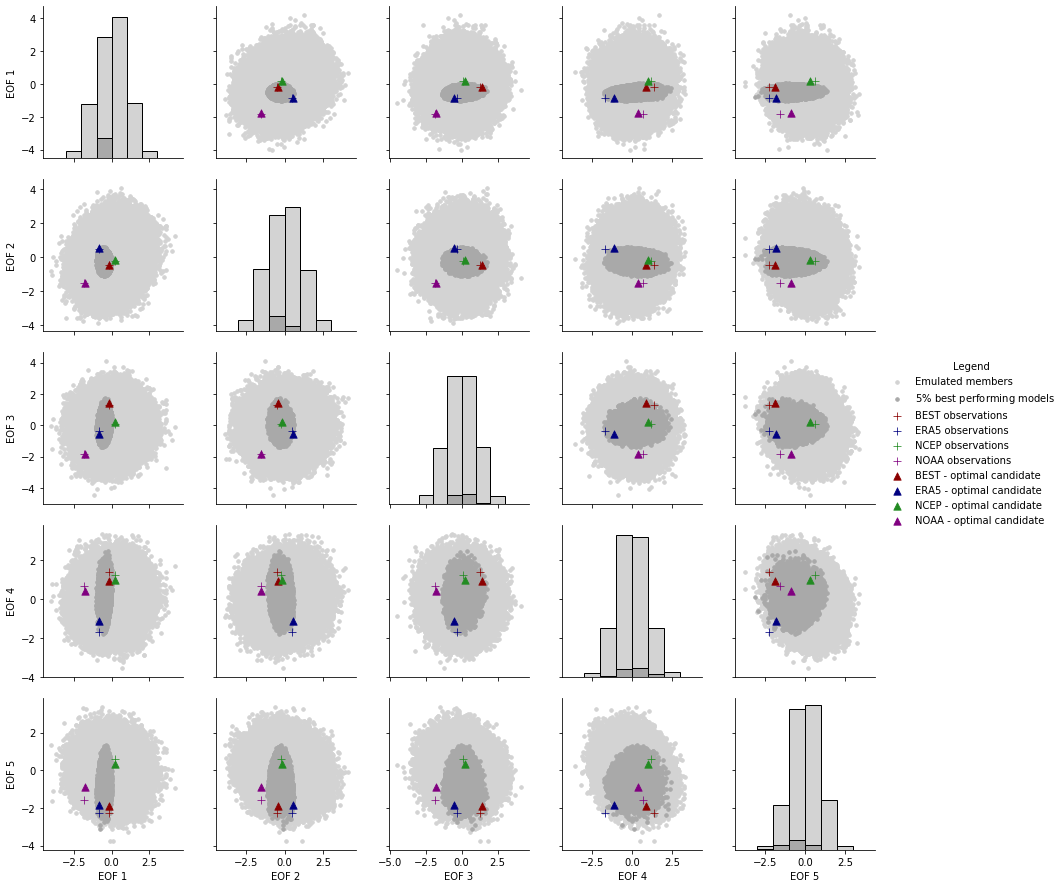

In [200]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray', 'darkgray','darkred','navy', 'forestgreen', 'purple', 'darkred', 'navy', 'forestgreen', 'purple']
m = ['.','.', '+', '+', '+', '+', '^', '^', '^', '^']
n = [-4,-3,-2,-1,0,1,2,3,4]
sns.pairplot(df_pc_norm_sort_optim, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None, s=55), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Fig5_trade-offs.png'
plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()